In [4]:
import pandas as pd
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt
pd.options.display.max_columns=None
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# Read cleaned data 

In [5]:
data = pd.read_pickle('../data/cleaned/data_for_modeling.pkl')

In [6]:
data['Total_revenue'] = data.Revenue_MF+data.Revenue_CC+data.Revenue_CL
data=data[data.Total_revenue>0]

# Analyze total revenue column

In [7]:
def bin_plot_barchart(df, colname, col_min_val, col_max_val,bin_size, binned_colname):
    tmp = df.copy()
    bins = range(col_min_val, col_max_val+bin_size, bin_size)  # Create bins from 0 to 100 with a step of 10
    labels = [f'{i}-{i+bin_size-1}' for i in bins[:-1]]  # Create bin labels like '0-9', '10-19', etc.

    # Step 2: Bin the column using pd.cut()
    tmp[binned_colname] = pd.cut(tmp[colname], bins=bins, labels=labels, right=False)

    # Step 3: Count the number of values in each bin
    tmp_group_counts = (tmp[binned_colname].value_counts().sort_index() / tmp.shape[0])*100

    # Step 4: Plot a bar chart
    plt.figure(figsize=(8, 6))
    tmp_group_counts.plot(kind='bar', color='skyblue')
    plt.title(colname+' Distribution in Groups of '+str(bin_size))
    plt.xlabel(binned_colname)
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust the layout to fit everything
    plt.show()

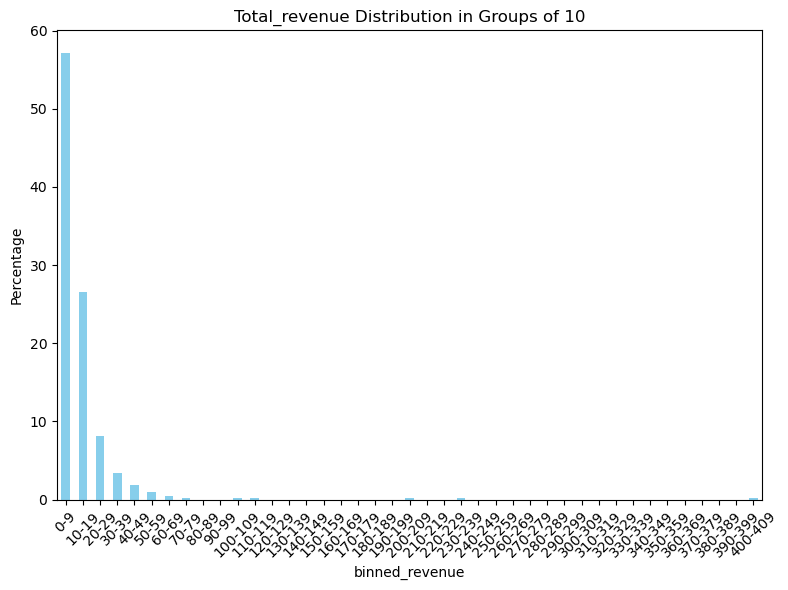

In [8]:
bin_plot_barchart(data, 'Total_revenue', 0, 410,10, 'binned_revenue')

In [9]:
data.Total_revenue.describe([0,.25,.5,.75,.85,.95,0.99,1])

count    418.000000
mean      13.796329
std       27.518151
min        0.004821
0%         0.004821
25%        3.580357
50%        8.446429
75%       15.784018
85%       20.403143
95%       37.349027
99%       97.847614
100%     407.962500
max      407.962500
Name: Total_revenue, dtype: float64

In [10]:
# Remove outliers
# Removing total revenue values where total revenue is above the 99 percentile value
data_sanitized = data[data.Total_revenue <98]

# Prepare data
Do train test split, use stratified sampling based on groups of Total_revenue values, as the distribution of values is skewed
Convert categorical values to one hot encoding
Scale numerical columns

In [11]:
Rev_bins = pd.qcut(data.Total_revenue, q=[0,.5,.75,.85,.95,1])  # Create quantile-based bins
Rev_bins

1      (0.0038199999999999996, 8.446]
4      (0.0038199999999999996, 8.446]
5                    (15.784, 20.403]
6                    (20.403, 37.349]
7                     (8.446, 15.784]
                    ...              
934                  (20.403, 37.349]
936                   (8.446, 15.784]
937    (0.0038199999999999996, 8.446]
945                  (15.784, 20.403]
946    (0.0038199999999999996, 8.446]
Name: Total_revenue, Length: 418, dtype: category
Categories (5, interval[float64, right]): [(0.0038199999999999996, 8.446] < (8.446, 15.784] < (15.784, 20.403] < (20.403, 37.349] < (37.349, 407.963]]

In [12]:
def prepare_data(full_data_with_labels,prep_config):
    assert full_data_with_labels.shape > (0,0) , "Error, dataset is empty"
    data_with_labels = full_data_with_labels.iloc[np.where((full_data_with_labels.Sale_MF+full_data_with_labels.Sale_CC+full_data_with_labels.Sale_CL)>0)[0],].copy()
    # Step 1 :  Encode categorical variables
    if len(prep_config["cat_cols_to_encode"]) > 0:
        assert set(prep_config["cat_cols_to_encode"]).issubset(set(data_with_labels.columns)), "Categorical columns are not in the dataset"
        data_encoded = pd.get_dummies(data_with_labels, columns=prep_config['cat_cols_to_encode'])
        print("Data with categorical variables encoded using one hot encoding")
        display(data_encoded.head())
    
    # Step 2 :  Split into training and test set
    dependent_variable = prep_config['target_variable']
    print("dependent variable :",set({dependent_variable}))
    
    ## Drop unnecessary columns
    cols_to_drop = set(['Sale_MF', 'Sale_CC', 'Sale_CL','Revenue_MF', 'Revenue_CC', 'Revenue_CL', 'Client']) - set({dependent_variable})  
    data_encoded.drop(columns=list(cols_to_drop),inplace=True)
    
    print("all columns:",data_encoded.columns)
    assert set({dependent_variable}).issubset(set(data_encoded.columns)), "Target variable provided not in the dataset"
    independent_variables = list(set(data_encoded.columns)-set({dependent_variable}))
    print("target_variable = ",dependent_variable)
    print("independent_variables = ",independent_variables)
    
    ## calculate stratification bins if data preparation for regression
    if prep_config["strat_for"] == 'regression':
        Rev_bins = pd.qcut(data_encoded.Total_revenue, q=[0,.5,.75,.85,.95,1])  # Create quantile-based bins
        stratify_based_on = Rev_bins
    else:
        stratify_based_on = data_encoded[dependent_variable]
        
    print("shape of independent variable ",data_encoded[independent_variables].shape)
    print("shape of dependent variable ", data_encoded[dependent_variable].shape)
    
    try:
        X_train, X_test, y_train, y_test = train_test_split(data_encoded[independent_variables], data_encoded[dependent_variable], test_size=prep_config['test_split_size'], random_state=50, stratify=stratify_based_on)
    except ValueError as e:
        print(f"ValueError: {e}")
    except Exception as e:
        print(f"Unexpected error: {e}")
    
    print(f"size of training set : {X_train.shape}")
    print(f"size of training set : {X_test.shape}")
    
    # Step 3 : Data normalization
    scaler = StandardScaler()
    try:
        X_train[prep_config['numeric_cols_to_standardize']] = scaler.fit_transform(X_train[prep_config['numeric_cols_to_standardize']])
        with open('./models/Regression/scaler.pkl','wb') as f:
            pickle.dump(scaler,f)
    except Exception as e:
        print(f"Unexpected error: {e}")
    print("X_train after normalization")
    display(X_train.head())
    print("X_train summary after normalization")
    display(X_train.describe())
    
    return X_train,X_test,y_train,y_test

In [13]:
prep_config = {
    "numeric_cols_to_standardize":['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
    "cat_cols_to_encode":['Sex'],
    "target_variable":'Total_revenue',
    "test_split_size": 0.2,
    "strat_for":'regression' # Can take two values, 'regression'/'classification'
}
X_train,X_test,y_train,y_test = prepare_data(data_sanitized, prep_config)

Data with categorical variables encoded using one hot encoding


,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL,Total_revenue,Sex_F,Sex_M
1,850,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,0.0,0.000000,0.0000,0.000000,0.000000,1392.402857,1392.402857,3,3,1226.345357,1226.345357,0.000000,0.000000,121.928571,6,6,0,0,1,0,1,0,0.0,0.893929,0.000000,0.893929,1,0
4,225,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,0.0,0.000000,618.3975,0.000000,0.000000,0.007500,0.007500,1,1,130.521429,130.521429,0.000000,111.235714,19.285714,5,5,0,4,1,0,0,1,0.0,0.000000,8.130714,8.130714,0,1
5,827,57,50,1,0.0,0.0,1.0,1.0,0.0,49.193571,0.0,0.000000,0.0000,0.464286,0.000000,1755.281786,1750.404286,9,6,1474.321429,1455.035714,607.142857,17.857143,843.250000,26,23,4,1,17,0,1,1,0.0,7.928571,12.242143,20.170714,0,1
6,1231,6,232,1,0.0,0.0,0.0,0.0,0.0,819.853929,0.0,0.000000,0.0000,0.000000,0.000000,0.015714,0.015714,2,2,2257.000000,2257.000000,2250.000000,0.000000,0.000000,9,9,6,0,0,0,0,1,0.0,0.000000,24.434643,24.434643,1,0
7,739,69,55,1,1.0,8.0,1.0,0.0,1.0,5519.308929,0.0,9824.236786,0.0000,0.000000,3868.679643,208.446786,150.003571,4,2,287.003571,282.575000,0.000000,211.182143,0.000000,7,5,0,3,0,0,1,1,0.0,2.138571,7.785714,9.924286,0,1


dependent variable : {'Total_revenue'}
all columns: Index(['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD',
       'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF',
       'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred', 'VolumeCred_CA',
       'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Total_revenue', 'Sex_F', 'Sex_M'],
      dtype='object')
target_variable =  Total_revenue
independent_variables =  ['Count_SA', 'ActBal_OVD', 'Age', 'VolumeCred', 'VolumeDebCashless_Card', 'ActBal_MF', 'VolumeDeb', 'Count_CC', 'TransactionsDeb', 'VolumeDeb_CA', 'Tenure', 'Count_MF', 'VolumeDebCash_Card', 'TransactionsDebCashless_Card', 'Sex_F', 'Count_CL', 'Count_CA', 'ActBal_CA', 'TransactionsCred_CA', 'Volu

,Count_SA,ActBal_OVD,Age,VolumeCred,VolumeDebCashless_Card,ActBal_MF,VolumeDeb,Count_CC,TransactionsDeb,VolumeDeb_CA,Tenure,Count_MF,VolumeDebCash_Card,TransactionsDebCashless_Card,Sex_F,Count_CL,Count_CA,ActBal_CA,TransactionsCred_CA,VolumeDeb_PaymentOrder,VolumeCred_CA,Count_OVD,TransactionsDebCash_Card,TransactionsCred,TransactionsDeb_PaymentOrder,Sex_M,ActBal_CL,ActBal_CC,ActBal_SA,TransactionsDeb_CA
830,1.569863,-0.221782,-1.226484,-0.868481,-0.623767,0.201251,-0.893447,-0.327693,-0.946779,-0.970638,-0.279760,0.209659,-0.669980,-0.676363,1,-0.286299,-0.264413,0.935922,-0.698441,-0.700439,-0.899301,-0.589015,-0.722331,-0.566048,-0.901270,0,-0.221113,-0.190496,0.695276,-1.018349
915,1.569863,-0.221782,-0.048514,2.399617,-0.623767,2.676762,0.287362,-0.327693,-0.502255,0.478487,1.617956,0.018004,-0.669980,-0.676363,1,-0.286299,-0.264413,0.442772,0.344480,2.035406,2.820130,-0.589015,-0.722331,0.403480,0.865139,0,-0.221113,-0.190496,1.500039,-0.449315
525,-0.461724,-0.221782,-0.048514,-0.752691,0.612190,-0.216118,-0.619260,-0.327693,0.132780,-0.634148,-0.620756,-0.173651,-0.574333,1.527120,0,-0.286299,-0.264413,-0.617137,-0.489857,-0.700439,-0.764821,-0.589015,-0.405350,-0.566048,-0.901270,1,-0.221113,-0.190496,-0.345159,0.363591
694,-0.461724,0.098492,0.647559,0.152634,0.830478,-0.216118,0.340048,-0.327693,2.228394,0.236190,0.950790,-0.173651,-0.669980,2.564054,0,-0.286299,-0.264413,-0.666052,1.804569,-0.110939,0.125410,1.697749,-0.722331,1.534597,1.085940,1,-0.221113,-0.190496,-0.345159,2.151984
598,-0.461724,-0.221782,-0.316235,-0.789057,-0.450492,-0.216118,-0.735906,-0.327693,-0.184737,-0.879482,0.624620,-0.173651,-0.563706,-0.287513,1,-0.286299,-0.264413,-0.666052,0.344480,-0.692371,-0.808506,1.697749,-0.405350,0.241892,-0.680469,0,-0.221113,-0.190496,-0.345159,-0.530606


X_train summary after normalization


,Count_SA,ActBal_OVD,Age,VolumeCred,VolumeDebCashless_Card,ActBal_MF,VolumeDeb,Count_CC,TransactionsDeb,VolumeDeb_CA,Tenure,Count_MF,VolumeDebCash_Card,TransactionsDebCashless_Card,Sex_F,Count_CL,Count_CA,ActBal_CA,TransactionsCred_CA,VolumeDeb_PaymentOrder,VolumeCred_CA,Count_OVD,TransactionsDebCash_Card,TransactionsCred,TransactionsDeb_PaymentOrder,Sex_M,ActBal_CL,ActBal_CC,ActBal_SA,TransactionsDeb_CA
count,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,330.000000,330.000000,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,3.300000e+02,330.000000,330.000000,330.000000,3.300000e+02,3.300000e+02
mean,2.422305e-17,2.691450e-18,-4.037175e-18,7.536059e-17,-4.306320e-17,2.691450e-17,-5.382900e-17,6.728624e-17,7.805204e-17,5.382900e-17,-9.689219e-17,4.306320e-17,3.229740e-17,2.254089e-17,0.490909,0.000000,-2.153160e-17,-1.111905e-16,-3.229740e-17,1.184238e-16,3.768030e-17,-2.691450e-17,-2.422305e-17,9.420074e-18,-4.575465e-17,0.509091,0.000000,0.000000,-4.710037e-17,-1.614870e-17
std,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,0.500677,1.001519,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,1.001519e+00,0.500677,1.001519,1.001519,1.001519e+00,1.001519e+00
min,-4.617243e-01,-2.217824e-01,-2.190278e+00,-8.705104e-01,-6.237667e-01,-2.161181e-01,-8.953846e-01,-3.276928e-01,-1.010282e+00,-9.730167e-01,-1.599266e+00,-1.736510e-01,-6.699801e-01,-6.763634e-01,0.000000,-0.286299,-2.644133e-01,-6.660522e-01,-9.070251e-01,-7.004394e-01,-8.993051e-01,-5.890151e-01,-7.223307e-01,-8.892240e-01,-9.012703e-01,0.000000,-0.221113,-0.190496,-3.451586e-01,-1.099640e+00
25%,-4.617243e-01,-2.217824e-01,-7.981316e-01,-6.728765e-01,-6.237667e-01,-2.161181e-01,-6.967491e-01,-3.276928e-01,-7.562684e-01,-7.439665e-01,-8.431449e-01,-1.736510e-01,-6.699801e-01,-6.763634e-01,0.000000,-0.286299,-2.644133e-01,-6.367895e-01,-4.898568e-01,-7.004394e-01,-6.872909e-01,-5.890151e-01,-7.223307e-01,-5.660479e-01,-9.012703e-01,0.000000,-0.221113,-0.190496,-3.451586e-01,-7.744776e-01
50%,-4.617243e-01,-2.217824e-01,-7.528625e-02,-3.420203e-01,-5.158021e-01,-2.161181e-01,-3.156385e-01,-3.276928e-01,-3.117442e-01,-2.790083e-01,-7.219768e-02,-1.736510e-01,-4.478729e-01,-5.467467e-01,0.000000,-0.286299,-2.644133e-01,-4.038761e-01,-2.812726e-01,-3.857213e-01,-3.066610e-01,-5.890151e-01,-4.053505e-01,-4.044598e-01,-2.388667e-01,1.000000,-0.221113,-0.190496,-3.451586e-01,-2.460888e-01
75%,-4.617243e-01,-2.217824e-01,7.546473e-01,2.910940e-01,2.158567e-01,-2.161181e-01,2.702334e-01,-3.276928e-01,4.502972e-01,3.537184e-01,7.654661e-01,-1.736510e-01,3.024312e-01,3.605700e-01,1.000000,-0.286299,-2.644133e-01,1.705734e-01,1.358957e-01,2.514985e-01,3.520727e-01,1.697749e+00,2.286100e-01,8.030437e-02,4.235368e-01,1.000000,-0.221113,-0.190496,-3.451586e-01,5.261718e-01
max,5.633036e+00,1.027648e+01,2.360970e+00,4.783244e+00,4.964695e+00,7.062094e+00,4.002855e+00,3.051639e+00,5.467070e+00,4.776436e+00,2.359251e+00,1.496709e+01,6.025311e+00,4.249071e+00,1.000000,6.012283,5.753268e+00,4.966843e+00,5.976253e+00,6.394009e+00,5.237677e+00,1.697749e+00,7.202175e+00,5.574298e+00,3.735555e+00,1.000000,9.094671,10.654293,5.412055e+00,5.322317e+00


# Train model using forward feature selection

In [14]:
ridge = Ridge(fit_intercept=True)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100,300,600]}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
sfs = SequentialFeatureSelector(grid_search, n_features_to_select='auto',scoring='neg_root_mean_squared_error', direction='forward', cv=5)
sfs.fit(X_train, y_train)
selected_features = sfs.get_support(indices=True)
print("Selected feature indices:", selected_features)

Selected feature indices: [ 3  5  6  8  9 11 13 14 19 20 23 25 26 27 29]


In [15]:
print("Selected features = ",X_train.columns[selected_features])

Selected features =  Index(['VolumeCred', 'ActBal_MF', 'VolumeDeb', 'TransactionsDeb',
       'VolumeDeb_CA', 'Count_MF', 'TransactionsDebCashless_Card', 'Sex_F',
       'VolumeDeb_PaymentOrder', 'VolumeCred_CA', 'TransactionsCred', 'Sex_M',
       'ActBal_CL', 'ActBal_CC', 'TransactionsDeb_CA'],
      dtype='object')


In [17]:
X_train_selected = X_train.iloc[:, selected_features]
best_model = grid_search.fit(X_train_selected, y_train)

with open('../models/Regression/best_model.pkl','wb') as f:
            pickle.dump(best_model,f)

In [ ]:
with open('./models/Regression/scaler.pkl','rb') as f:
    scaler = pickle.load(f)
x_test_scaled = X_test.copy()
x_test_scaled[prep_config["numeric_cols_to_standardize"]] = scaler.transform(X_test[prep_config["numeric_cols_to_standardize"]])
X_test_selected = x_test_scaled.iloc[:, selected_features]


y_pred = best_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
print("Test RMSE:", math.sqrt(mse))

In [18]:
X_train_selected.columns

Index(['VolumeCred', 'ActBal_MF', 'VolumeDeb', 'TransactionsDeb',
       'VolumeDeb_CA', 'Count_MF', 'TransactionsDebCashless_Card', 'Sex_F',
       'VolumeDeb_PaymentOrder', 'VolumeCred_CA', 'TransactionsCred', 'Sex_M',
       'ActBal_CL', 'ActBal_CC', 'TransactionsDeb_CA'],
      dtype='object')